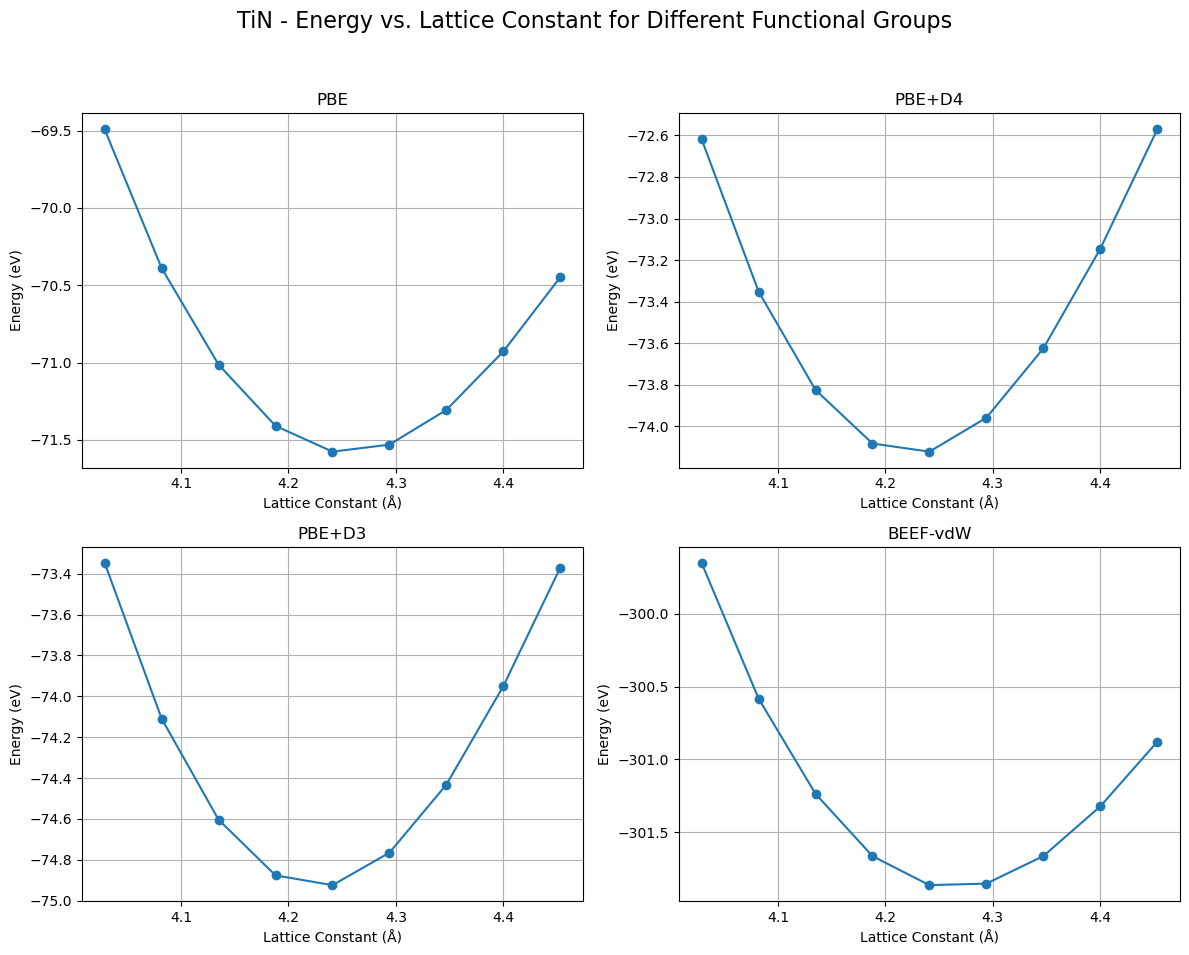

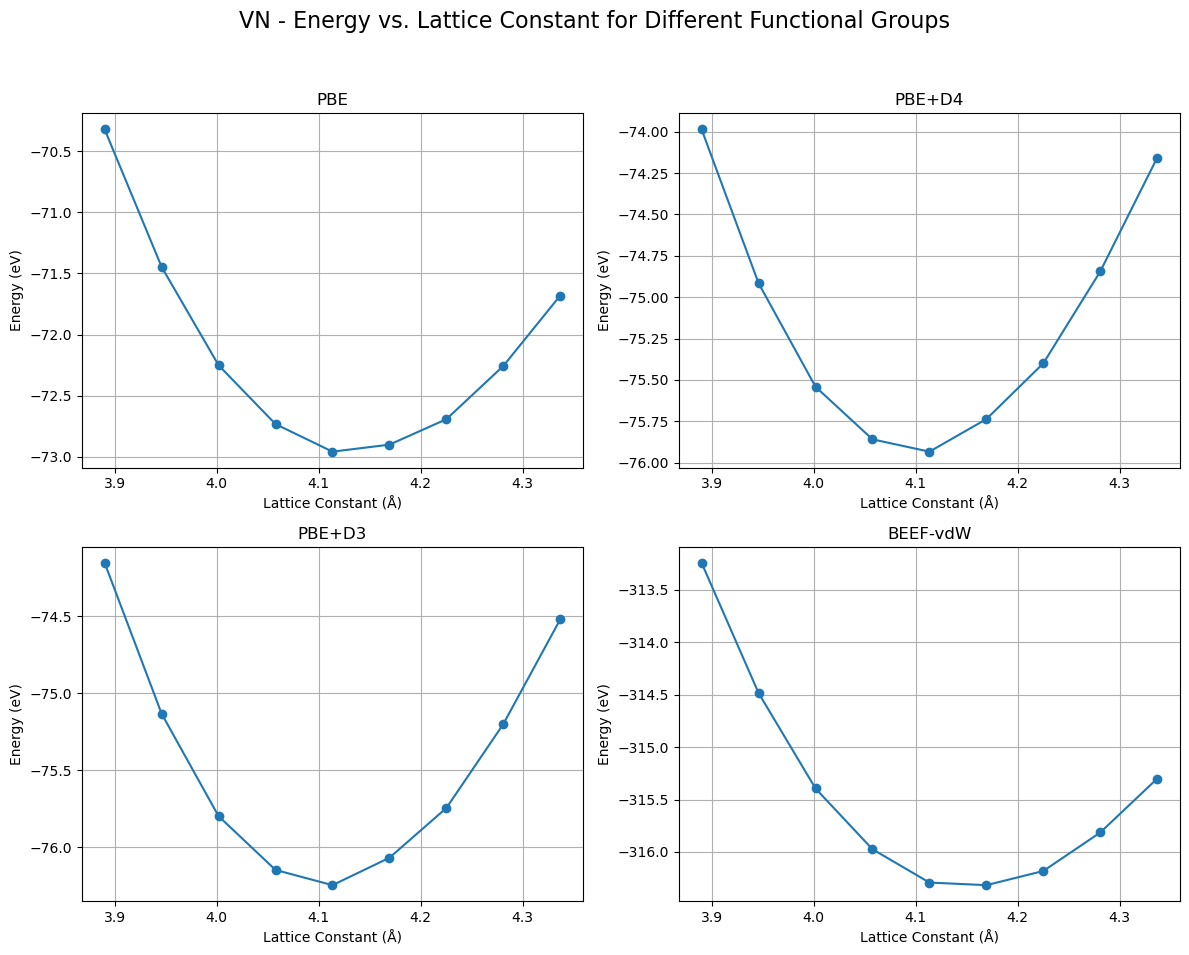

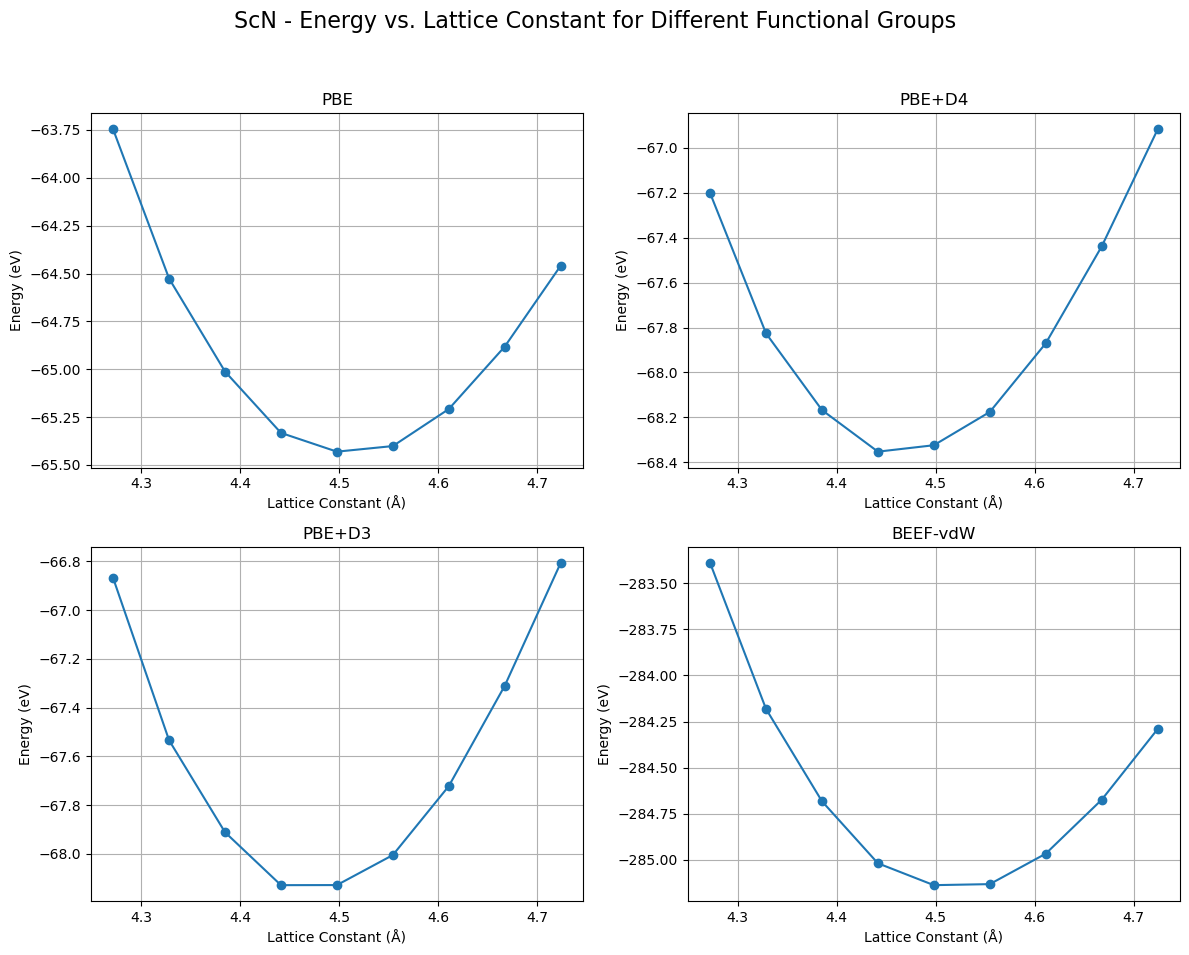

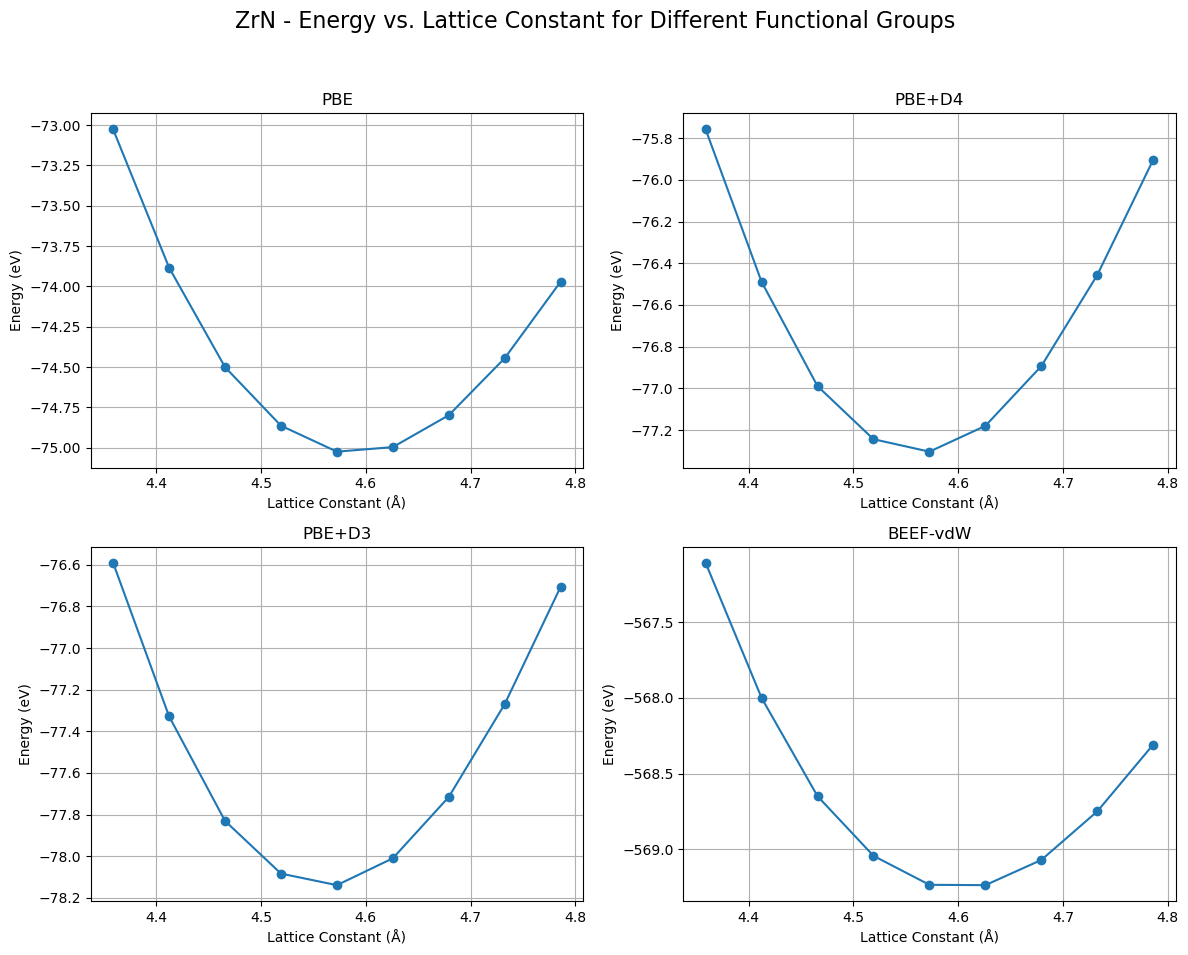

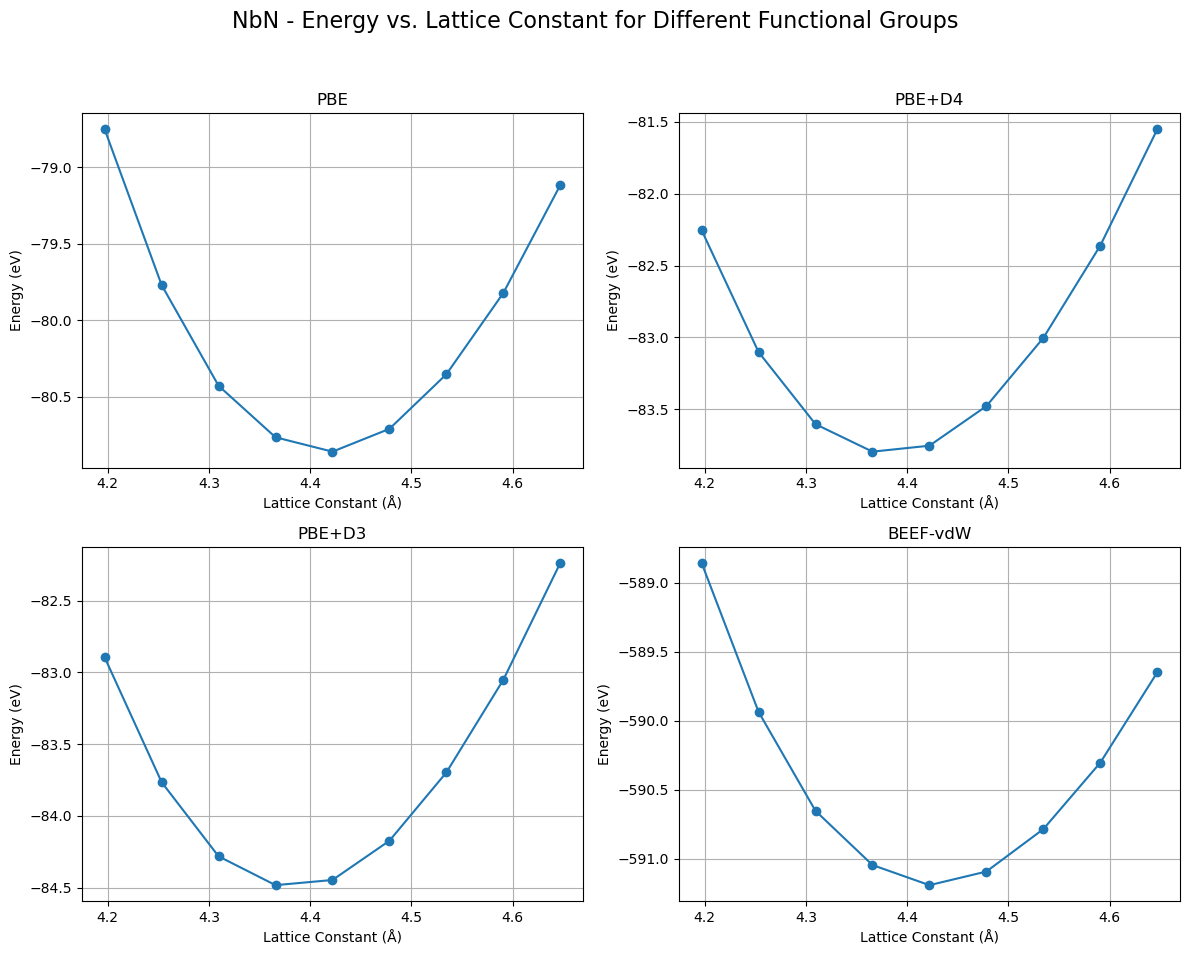

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# List your 4 CSV files here
csv_files = ['pbe_results.csv', 'pbe_d4_results.csv', 'pbe_d3_results.csv', 'beef_vdw_results.csv']

# Read and concatenate all data
dfs = [pd.read_csv(f) for f in csv_files]
data = pd.concat(dfs, ignore_index=True)

# Get unique materials (metals in your case)
unique_materials = data['Material'].unique()

# Get unique functional groups
unique_functional_groups = data['Functional'].unique()

# Plot for each material
for mat in unique_materials:
    # Create a figure and a set of subplots for the current material
    # We'll use 2x2 grid for 4 subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle(f'{mat} - Energy vs. Lattice Constant for Different Functional Groups', fontsize=16)

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through unique functional groups and plot on subplots
    for i, func in enumerate(unique_functional_groups):
        subset = data[(data['Material'] == mat) & (data['Functional'] == func)]

        # Check if there's data for this material and functional group
        if not subset.empty:
            axes[i].plot(subset['Lattice_Constant'], subset['Energy'], marker='o', linestyle='-')
            axes[i].set_xlabel('Lattice Constant (Å)')
            axes[i].set_ylabel('Energy (eV)')
            axes[i].set_title(f'{func}')
            axes[i].grid(True)
        else:
            # If no data, you might want to hide the subplot or add a placeholder text
            axes[i].set_visible(False) # Hides the subplot if no data

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

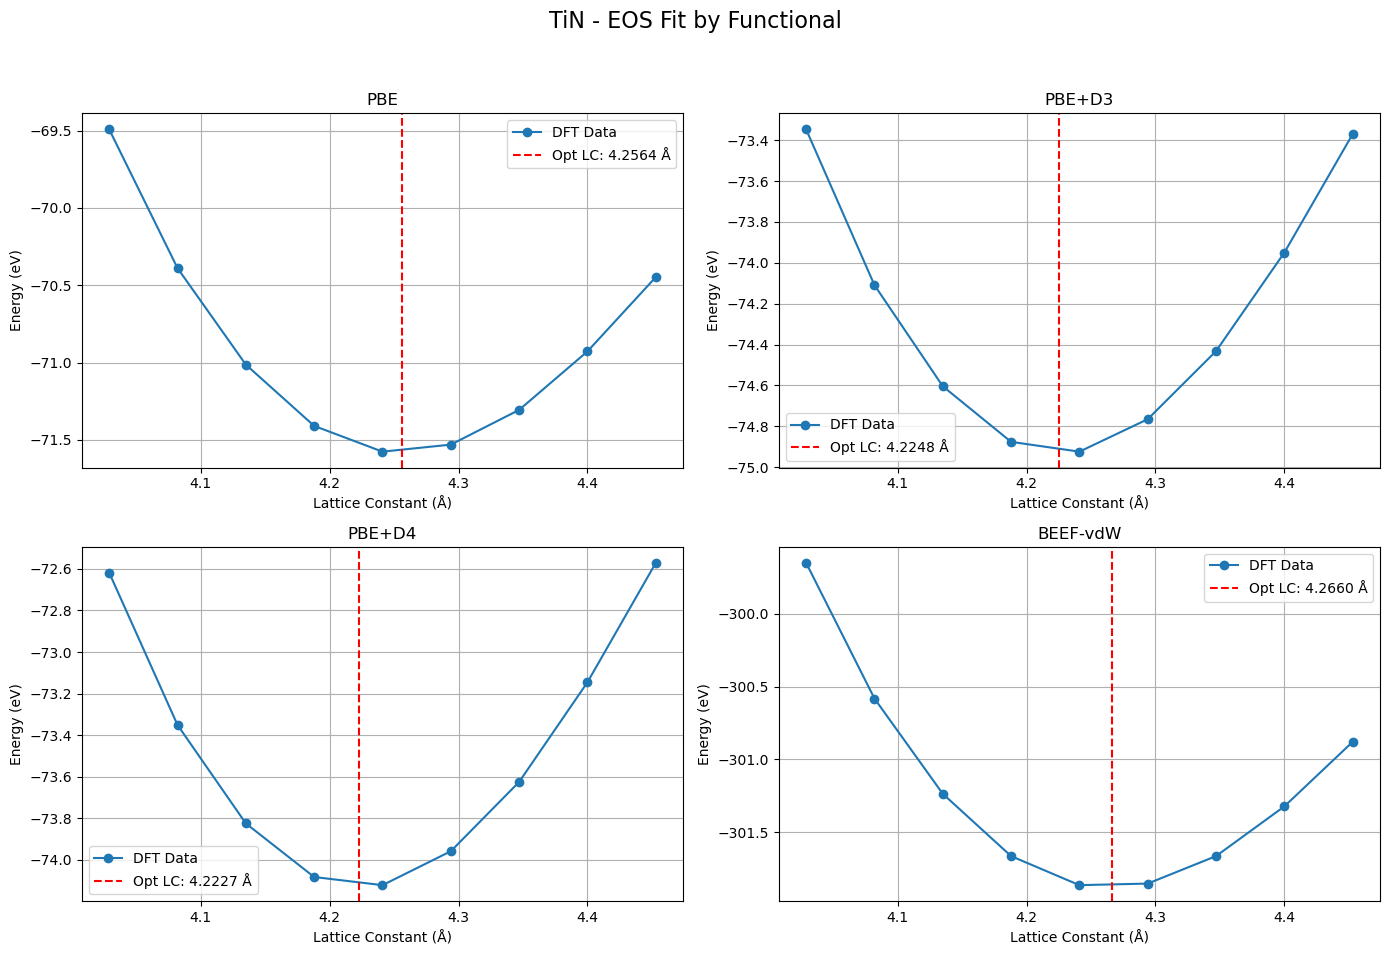

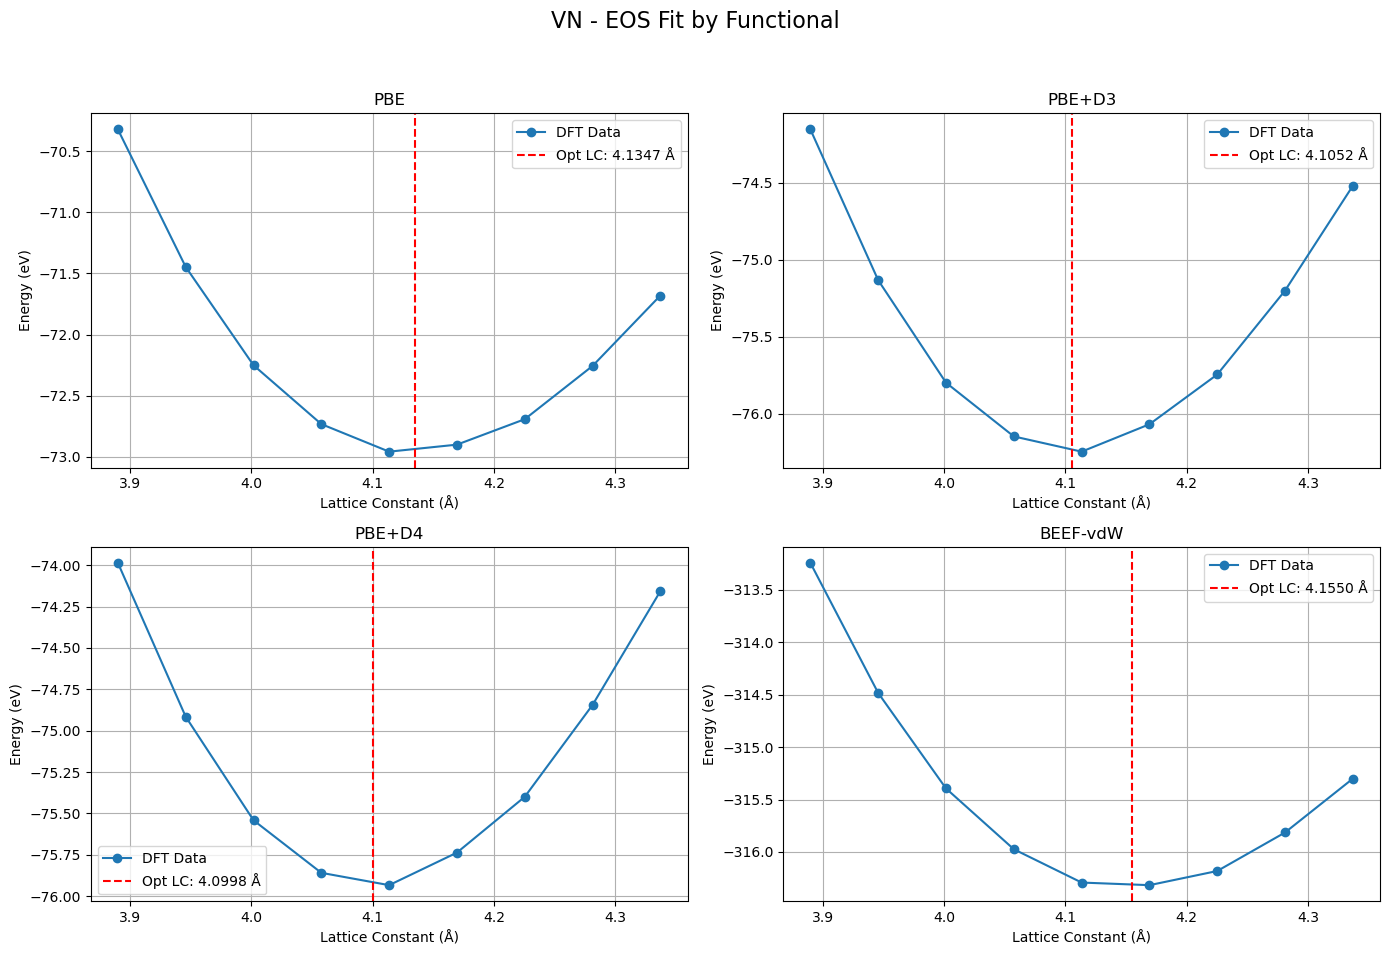

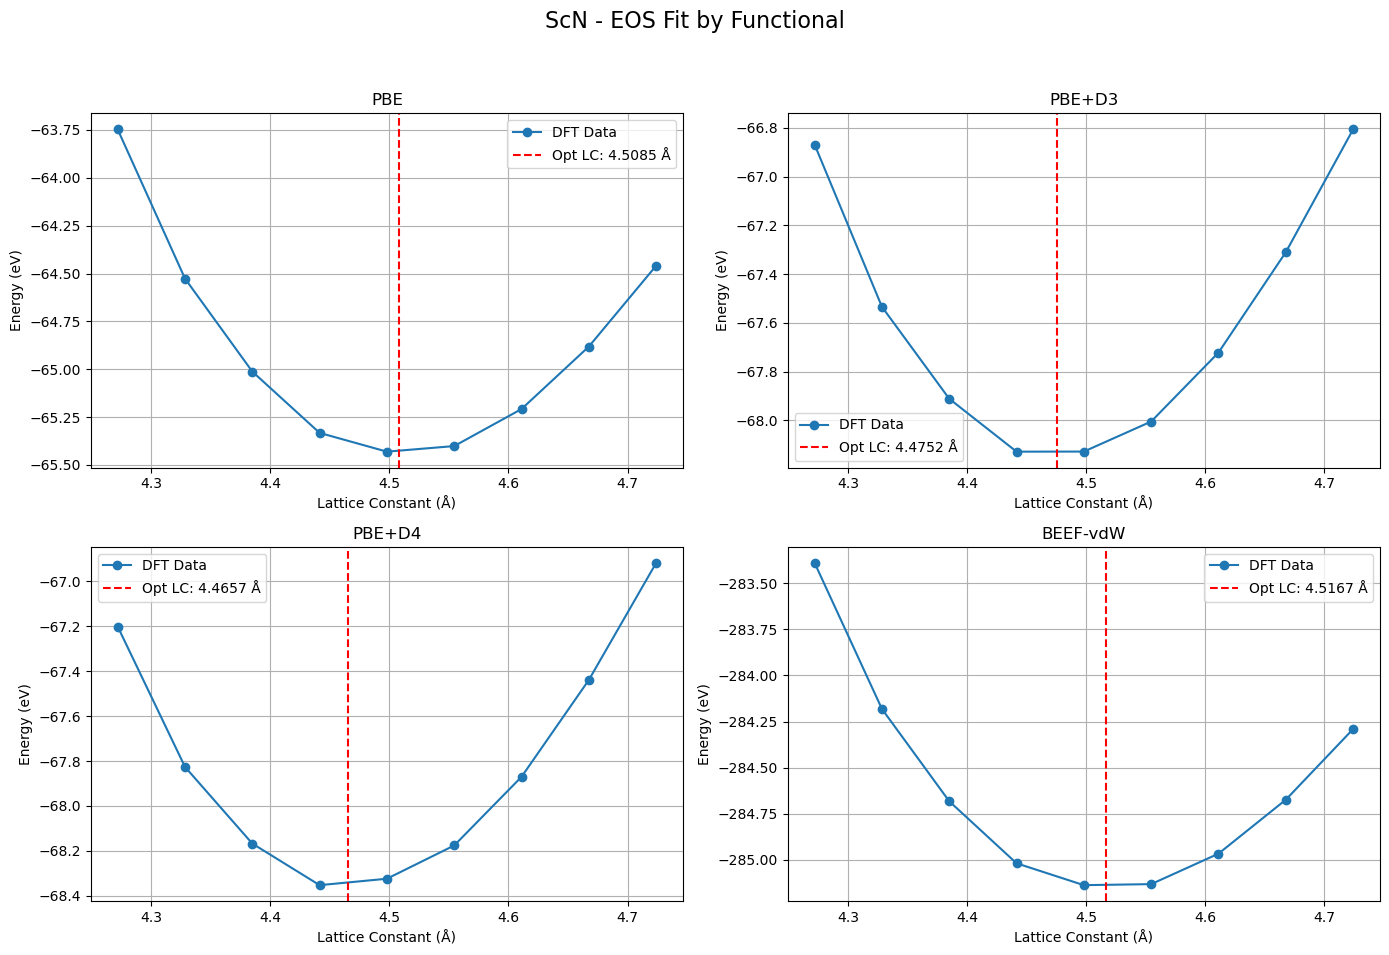

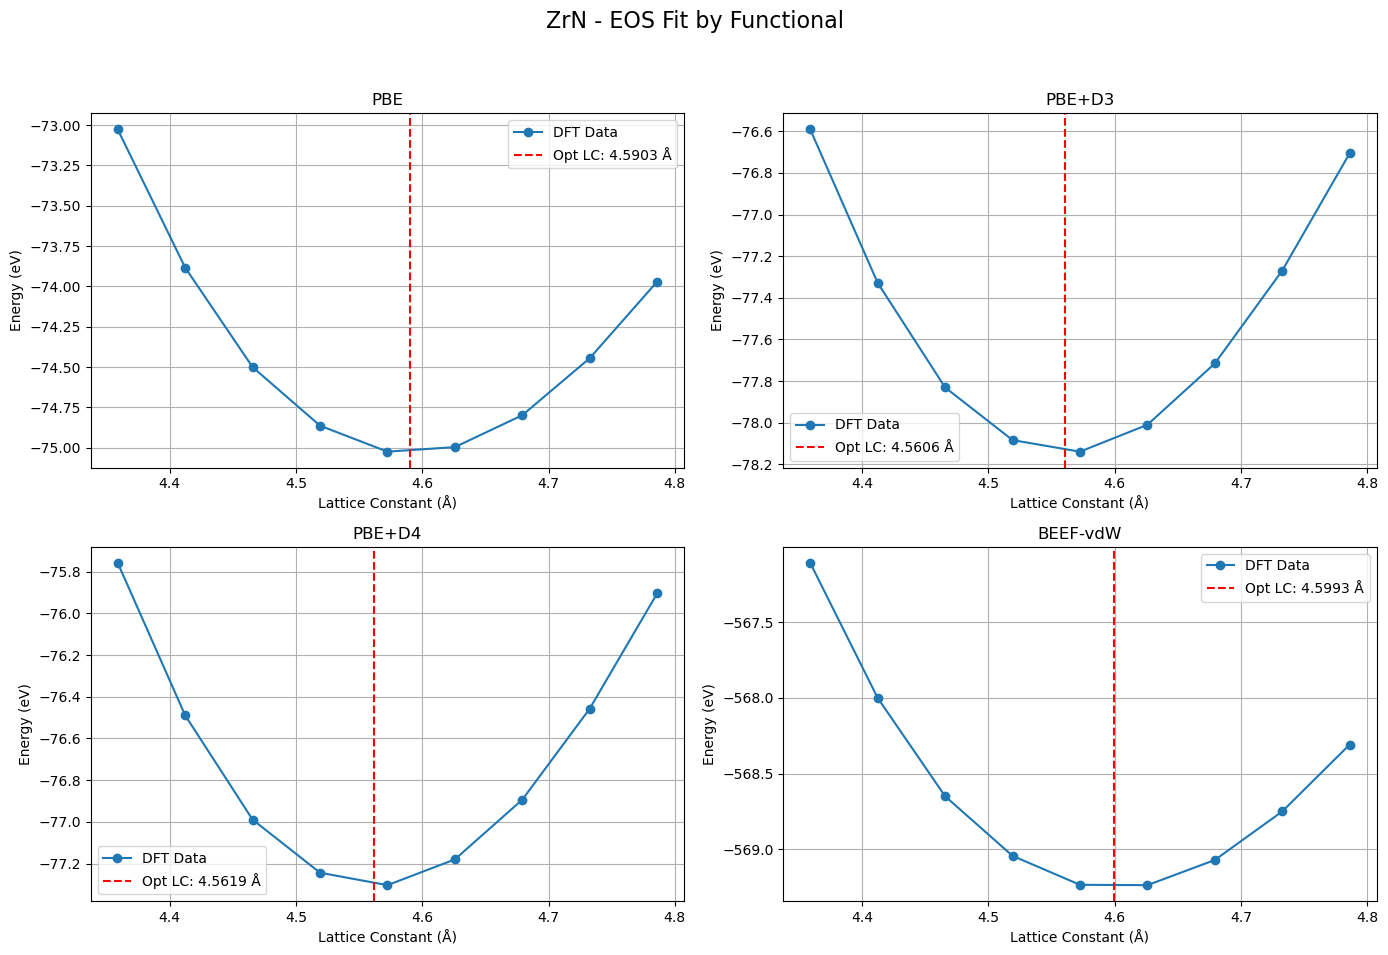

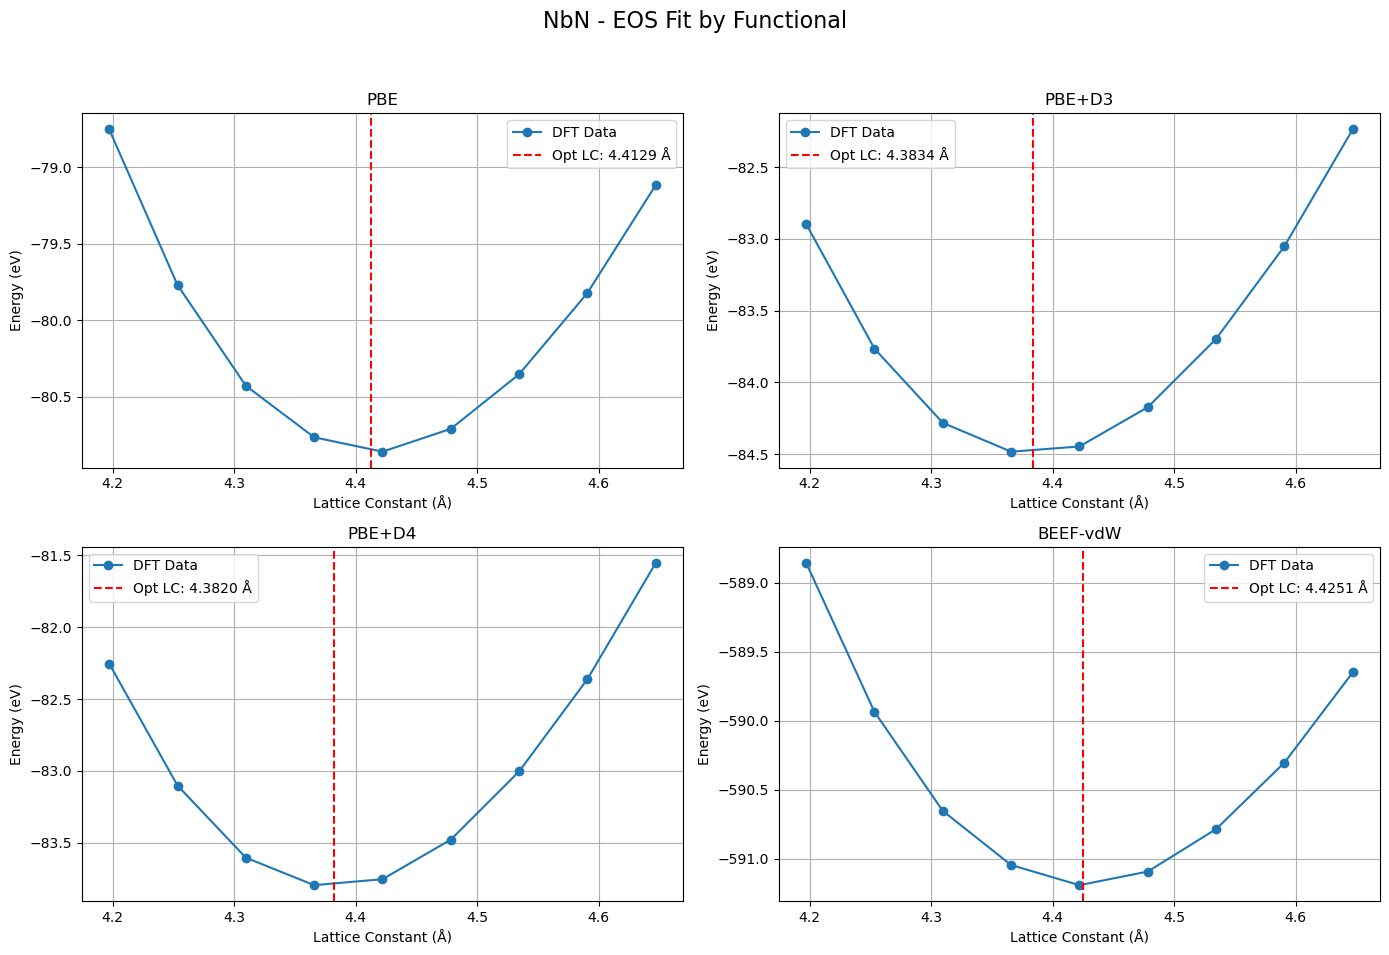


--- EOS Fit Summary ---
Material Functional  Equilibrium_Lattice_Constant  Equilibrium_Volume  Minimum_Energy  Bulk_Modulus
     TiN        PBE                      4.256429           77.114508      -71.572068      1.769075
     TiN     PBE+D3                      4.224825           75.409534      -74.920883      1.863745
     TiN     PBE+D4                      4.222713           75.296463      -74.120395      1.825881
     TiN   BEEF-vdW                      4.265981           77.634831     -301.872159      1.716397
      VN        PBE                      4.134695           70.685519      -72.961060      1.957371
      VN     PBE+D3                      4.105173           69.182180      -76.235024      2.058121
      VN     PBE+D4                      4.099841           68.912978      -75.927186      2.034433
      VN   BEEF-vdW                      4.154965           71.730198     -316.340920      1.923180
     ScN        PBE                      4.508453           91.639489      

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ase.eos import EquationOfState

# Load your data files
dfs = {
    'PBE': pd.read_csv('pbe_results.csv'),
    'PBE+D3': pd.read_csv('pbe_d3_results.csv'),
    'PBE+D4': pd.read_csv('pbe_d4_results.csv'),
    'BEEF-vdW': pd.read_csv('beef_vdw_results.csv')
}

materials = ['TiN', 'VN', 'ScN', 'ZrN', 'NbN']
eos_summary = []

for material in materials:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle(f'{material} - EOS Fit by Functional', fontsize=16)

    for ax, (functional, df) in zip(axes.ravel(), dfs.items()):
        data = df[df['Material'] == material]
        if data.empty:
            ax.set_title(f'{functional} - No Data')
            ax.axis('off')
            continue

        lattice_constants = data['Lattice_Constant'].values
        energies = data['Energy'].values
        volumes = lattice_constants ** 3

        try:
            eos = EquationOfState(volumes, energies)
            v0, e0, B = eos.fit()
            lc_eq = v0 ** (1 / 3)

            ax.plot(lattice_constants, energies, 'o-', label='DFT Data')
            ax.axvline(lc_eq, color='r', linestyle='--', label=f'Opt LC: {lc_eq:.4f} Å')
            ax.set_title(f'{functional}')
            ax.set_xlabel('Lattice Constant (Å)')
            ax.set_ylabel('Energy (eV)')
            ax.legend()
            ax.grid(True)

            eos_summary.append({
                'Material': material,
                'Functional': functional,
                'Equilibrium_Lattice_Constant': lc_eq,
                'Equilibrium_Volume': v0,
                'Minimum_Energy': e0,
                'Bulk_Modulus': B
            })
        except Exception as e:
            ax.set_title(f'{functional} - EOS Fit Failed')
            ax.text(0.5, 0.5, str(e), ha='center', va='center')
            ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Print EOS fit summary
summary_df = pd.DataFrame(eos_summary)
print("\n--- EOS Fit Summary ---")
print(summary_df.to_string(index=False))

# Optional: save the summary to CSV
# summary_df.to_csv('eos_fit_summary.csv', index=False)


In [17]:
from ase.io import read, write
import os

# Optimized lattice constants (skipping PBE)
lattice_constants = {
    'TiN': {'D3': 4.224825, 'D4': 4.222713, 'BEEF': 4.265981},
    'VN': {'D3': 4.105173, 'D4': 4.099841, 'BEEF': 4.154965},
    'ScN': {'D3': 4.475153, 'D4': 4.465668, 'BEEF': 4.516714},
    'ZrN': {'D3': 4.560577, 'D4': 4.561882, 'BEEF': 4.599342},
    'NbN': {'D3': 4.383374, 'D4': 4.381987, 'BEEF': 4.425092}
}

def rescale_and_save(metal, functional_short, new_lc):
    cif_file = f'{metal}.cif'
    if not os.path.exists(cif_file):
        print(f"Missing CIF file: {cif_file}")
        return

    atoms = read(cif_file)
    a0 = atoms.get_cell_lengths_and_angles()[0]
    scale = new_lc / a0

    atoms_new = atoms.copy()
    atoms_new.set_cell(atoms.get_cell() * scale, scale_atoms=True)

    outname = f"{metal}_{functional_short}"
    write(f"{outname}.xyz", atoms_new)
    write(f"{outname}.cif", atoms_new)
    print(f"Saved {outname}.xyz and {outname}.cif with LC = {new_lc:.4f} Å")

# Process each material and functional
for metal, func_lc in lattice_constants.items():
    for func_clean, lc in func_lc.items():
        rescale_and_save(metal, func_clean, lc)


Saved TiN_D3.xyz and TiN_D3.cif with LC = 4.2248 Å
Saved TiN_D4.xyz and TiN_D4.cif with LC = 4.2227 Å
Saved TiN_BEEF.xyz and TiN_BEEF.cif with LC = 4.2660 Å
Saved VN_D3.xyz and VN_D3.cif with LC = 4.1052 Å
Saved VN_D4.xyz and VN_D4.cif with LC = 4.0998 Å
Saved VN_BEEF.xyz and VN_BEEF.cif with LC = 4.1550 Å
Saved ScN_D3.xyz and ScN_D3.cif with LC = 4.4752 Å
Saved ScN_D4.xyz and ScN_D4.cif with LC = 4.4657 Å
Saved ScN_BEEF.xyz and ScN_BEEF.cif with LC = 4.5167 Å
Saved ZrN_D3.xyz and ZrN_D3.cif with LC = 4.5606 Å
Saved ZrN_D4.xyz and ZrN_D4.cif with LC = 4.5619 Å
Saved ZrN_BEEF.xyz and ZrN_BEEF.cif with LC = 4.5993 Å
Saved NbN_D3.xyz and NbN_D3.cif with LC = 4.3834 Å
Saved NbN_D4.xyz and NbN_D4.cif with LC = 4.3820 Å
Saved NbN_BEEF.xyz and NbN_BEEF.cif with LC = 4.4251 Å


/tmp/ipykernel_7350/1151003096.py:20: DeprecationWarning: Please use atoms.cell.cellpar() instead
  a0 = atoms.get_cell_lengths_and_angles()[0]


In [21]:
from ase.io import read
from ase.visualize import view
view(read('VN_D4.cif'))
view(read('VN.cif'))
view(read('ZrN_D4.xyz'))

<Popen: returncode: None args: ['/home/ameerracle/miniconda3/envs/gpaw/bin/p...>